# HW_8

In [110]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [111]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [112]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантаження даних
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворення та нормалізація даних
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

# Перемішування тренувальних даних
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [113]:
# Створення нейронної мережі з Dropout
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0, dropout_rate=0.0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            y = tf.nn.softmax(y)
        else:
            y = tf.nn.sigmoid(y)
        if dropout_rate > 0:
            y = tf.nn.dropout(y, rate=dropout_rate)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x, training=False):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=1, dropout_rate=0.2)
        x = self.layer2(x, activation=1, dropout_rate=0.2)
        x = self.out_layer(x, activation=0)
        return x

In [114]:
# Функція помилки
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Функція точності
def accuracy(y_pred, y_true):
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [115]:
# Функція навчання
def train(neural_net, input_x, output_y, dropout_rate=0.0):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x, training=True)
        loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [116]:
# Тренування мережі
neural_net = NN(name="mnist")
loss_history = []
accuracy_history = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print("Шаг: %i, Поточна втрата: %f, Точність: %f" % (step, loss, acc))

Шаг: 100, Поточна втрата: 83.617264, Точність: 0.070312
Шаг: 200, Поточна втрата: 50.379166, Точність: 0.113281
Шаг: 300, Поточна втрата: 34.882965, Точність: 0.125000
Шаг: 400, Поточна втрата: 26.553688, Точність: 0.132812
Шаг: 500, Поточна втрата: 21.435616, Точність: 0.113281
Шаг: 600, Поточна втрата: 17.849663, Точність: 0.089844
Шаг: 700, Поточна втрата: 15.393406, Точність: 0.093750
Шаг: 800, Поточна втрата: 13.261377, Точність: 0.125000
Шаг: 900, Поточна втрата: 11.811787, Точність: 0.121094
Шаг: 1000, Поточна втрата: 10.673155, Точність: 0.093750
Шаг: 1100, Поточна втрата: 9.658142, Точність: 0.085938
Шаг: 1200, Поточна втрата: 8.709106, Точність: 0.109375
Шаг: 1300, Поточна втрата: 8.058222, Точність: 0.136719
Шаг: 1400, Поточна втрата: 7.530376, Точність: 0.070312
Шаг: 1500, Поточна втрата: 6.989388, Точність: 0.132812
Шаг: 1600, Поточна втрата: 6.557877, Точність: 0.109375
Шаг: 1700, Поточна втрата: 6.106517, Точність: 0.121094
Шаг: 1800, Поточна втрата: 5.824912, Точність: 

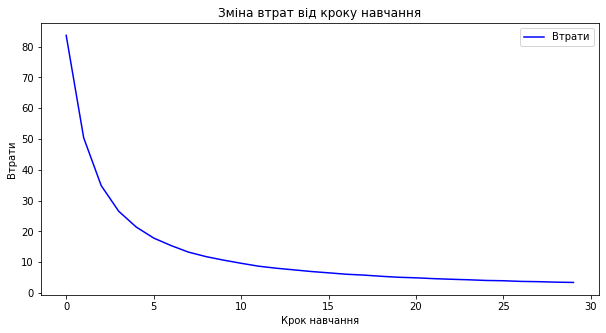

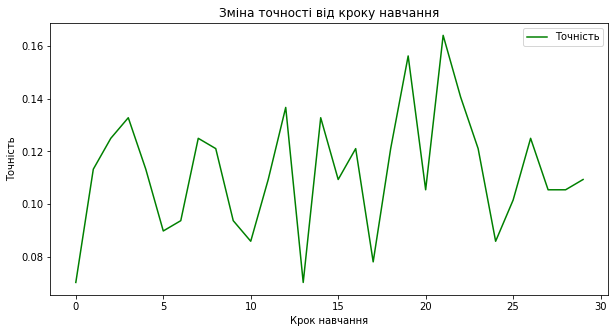

In [117]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведення графіків
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрати', color='blue')
plt.title('Зміна втрат від кроку навчання')
plt.xlabel('Крок навчання')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='green')
plt.title('Зміна точності від кроку навчання')
plt.xlabel('Крок навчання')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [118]:
# Обчислення точності та втрат на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
test_loss = cross_entropy(test_pred, y_test)
print("Точність на тестових даних: {:.4f}".format(test_accuracy))
print("Втрати на тестових даних: {:.4f}".format(test_loss))

Точність на тестових даних: 0.1159
Втрати на тестових даних: 133.3833


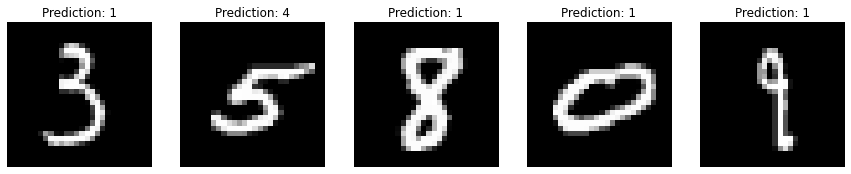

In [119]:
# Тестування навченої мережі на декількох зображеннях
num_images_to_test = 5
random_indices = np.random.choice(x_test.shape[0], num_images_to_test, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]
predictions = neural_net(images_to_test)

plt.figure(figsize=(15, 5))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i+1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title('Prediction: {}'.format(np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

In [120]:
'''Висновки:

1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, 
оскільки більшість передбачень вірно збігаються з фактичними мітками. 
Однак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.

2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. 
Наприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.
'''

'Висновки:\n\n1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, \nоскільки більшість передбачень вірно збігаються з фактичними мітками. \nОднак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.\n\n2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. \nНаприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.\n'